In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.append(os.path.abspath("src"))

from lab5.constants import DEFAULT_SEED, FS_SPIKE
from lab5.figures import apply_style, compute_global_ylim, save_figure, set_shared_limits
from lab5.io_mat import load_mat
from lab5.lfp import LFP_spectrum
from lab5.paths import DATA_DIR, PLOTS_FINAL_DIR
from lab5.signal import plotSignal
from lab5.spikes import (
    align_spike_times,
    convert_waveforms_to_uv,
    ensure_waveforms_2d,
    plotSpikes,
)


apply_style()

RAW_MAT_PATH = DATA_DIR / "Ch01 walk daniil.mat"
LFP_MAT_PATH = DATA_DIR / "LFP_data.mat"


# Part 1 — Signal filtering


(PosixPath('/Users/ilya/Downloads/neurolab-5/plots/final/part1_ch01_walk_daniil_signal.png'),)

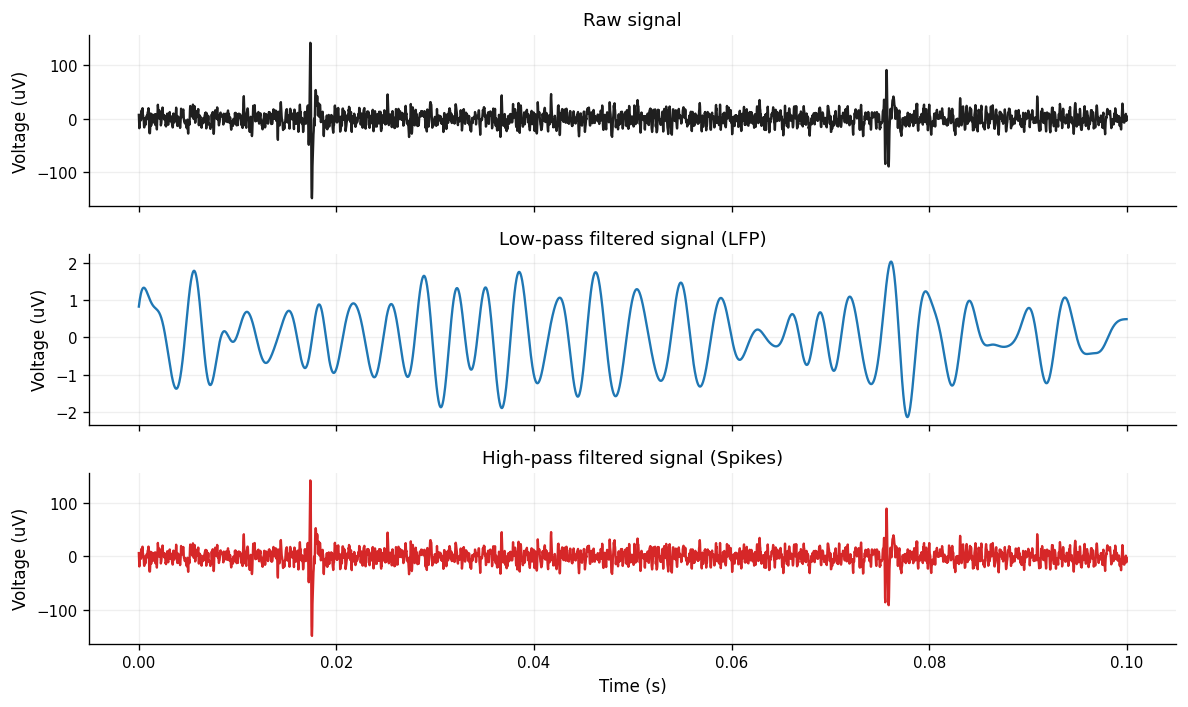

In [2]:
mat = load_mat(RAW_MAT_PATH)
spk01 = mat["SPK01"]
raw = spk01[:, 0]
fig, _ = plotSignal(raw, t_start=0.0, t_duration=0.1)
save_figure(fig, "part1_ch01_walk_daniil_signal")


The raw extracellular signal contains a mixture of slow fluctuations, fast transients, and background noise. In the unfiltered trace, action potentials appear as brief, high-amplitude deflections embedded within lower-amplitude, slower variations, making it difficult to isolate specific components of neural activity.

Applying a low-pass filter preserves the slow components of the signal while attenuating rapid voltage changes. As a result, sharp spike waveforms are removed and the signal becomes dominated by smooth, oscillatory fluctuations corresponding to local field potentials (LFPs), which reflect the summed synaptic and dendritic activity of nearby neuronal populations.

In contrast, applying a high-pass filter removes the slow fluctuations and emphasizes fast transients. This filtering isolates the brief, high-frequency components associated with action potentials, allowing individual spikes to be clearly distinguished from the background signal.

Overall, filtering decomposes the original raw signal into functionally distinct components: low-frequency activity related to population-level synaptic dynamics and high-frequency activity corresponding to single-neuron spiking.

# Part 2 — Spike waveforms


In [3]:
# Part 2 dataset selection
P2_STAND_PATH = DATA_DIR / "Ch20 stand Carmel.mat"
P2_WALK_PATH = DATA_DIR / "Ch20 walk Carmel.mat"
P2_PERSON_A_PATH = DATA_DIR / "Ch01 stand Ohad.mat"
P2_PERSON_B_PATH = DATA_DIR / "Ch01 stand Sagi.mat"

P2_STAND_WF_KEYS = ("SPK20a_wf", "SPK20b_wf")
P2_PERSON_WF_KEYS = ("SPK01a_wf", "SPK01b_wf", "SPK01c_wf")


In [4]:
def prepare_channel_waveforms(mat, wf_keys):
    per_unit = {}
    all_waveforms = []
    units = set()
    conversions = set()
    for wf_key in wf_keys:
        wf_raw = mat[wf_key]
        times_key = wf_key.replace("_wf", "")
        spike_times = np.asarray(mat[times_key]).reshape(-1)
        wf, wf_info = ensure_waveforms_2d(wf_raw, n_spikes_expected=spike_times.size)
        spike_times, wf, time_info = align_spike_times(spike_times, wf)
        wf_uv, unit_info = convert_waveforms_to_uv(wf)
        units.add(unit_info["units_label"])
        conversions.add(unit_info["converted"])
        info = {
            "wf_key": wf_key,
            "times_key": times_key,
            **wf_info,
            **time_info,
            **unit_info,
        }
        per_unit[wf_key] = info
        all_waveforms.append(wf_uv)
    wf_channel = np.concatenate(all_waveforms, axis=1) if len(all_waveforms) > 1 else all_waveforms[0]
    if len(units) > 1:
        print(f"Warning: mixed units detected: {units}")
    if len(conversions) > 1:
        print(f"Warning: mixed conversion decisions detected: {conversions}")
    return wf_channel, per_unit


Condition comparison counts: 1048 1057 ylim (np.float64(-416110.9924316406), np.float64(344598.13435872394))
People comparison counts: 855 853 ylim (np.float64(-271288.55387369794), np.float64(232810.97412109375))


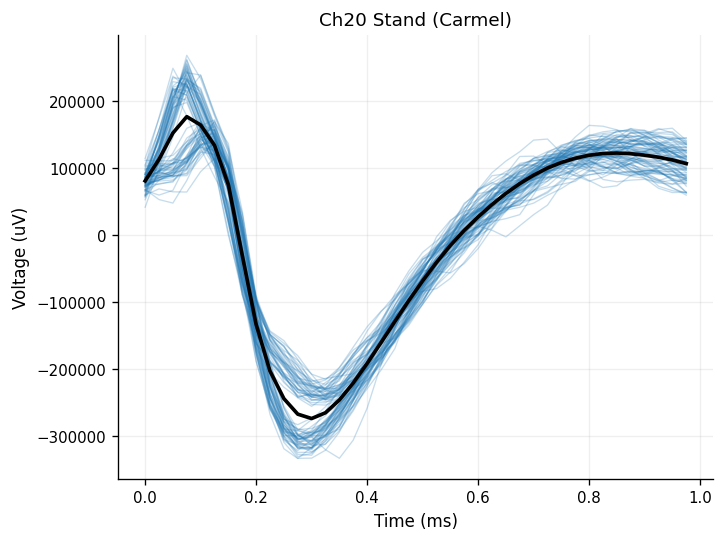

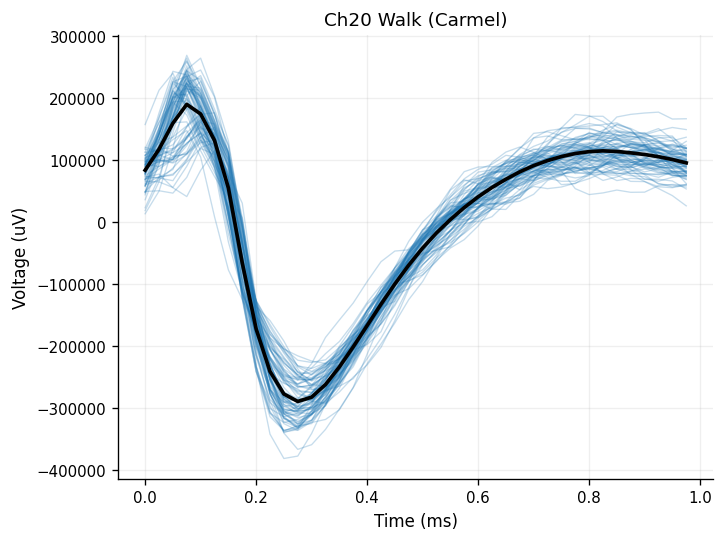

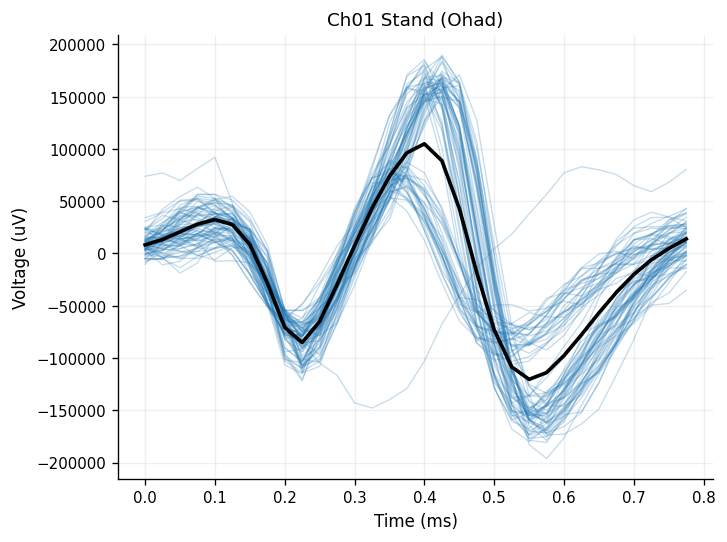

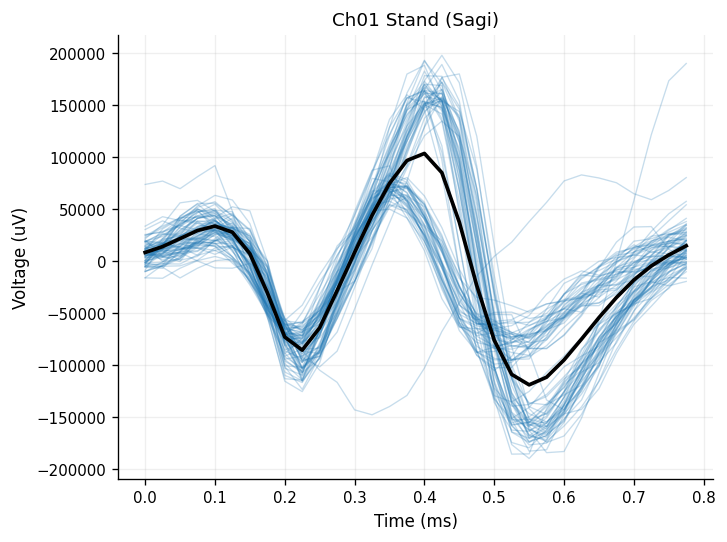

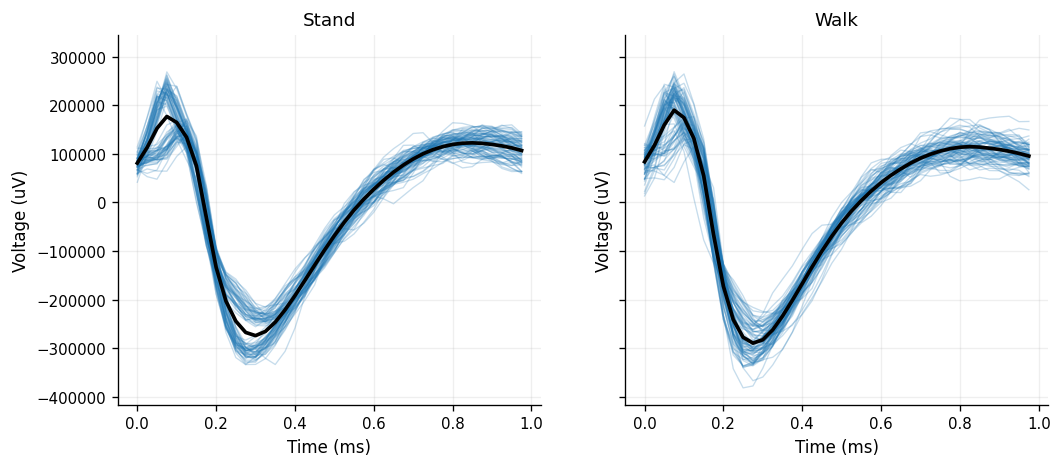

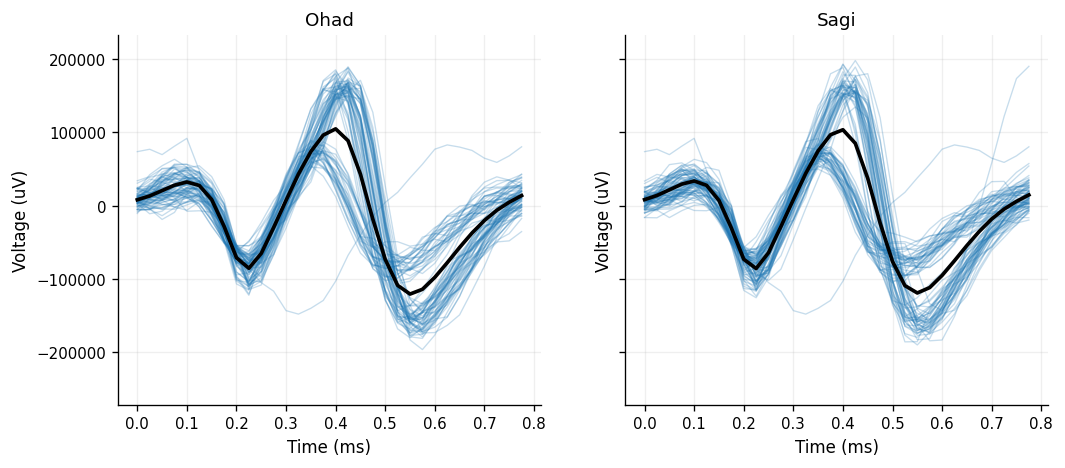

In [5]:
stand_mat = load_mat(P2_STAND_PATH)
walk_mat = load_mat(P2_WALK_PATH)
person_a_mat = load_mat(P2_PERSON_A_PATH)
person_b_mat = load_mat(P2_PERSON_B_PATH)

wf_stand, info_stand = prepare_channel_waveforms(stand_mat, P2_STAND_WF_KEYS)
wf_walk, info_walk = prepare_channel_waveforms(walk_mat, P2_STAND_WF_KEYS)
wf_person_a, info_person_a = prepare_channel_waveforms(person_a_mat, P2_PERSON_WF_KEYS)
wf_person_b, info_person_b = prepare_channel_waveforms(person_b_mat, P2_PERSON_WF_KEYS)

n_plot = 80
seed = DEFAULT_SEED
fs = FS_SPIKE
units_label = "uV"

# Figure set A: random waveforms from channel + mean
fig, _ = plotSpikes(wf_stand, n=n_plot, seed=seed, fs=fs, title="Ch20 Stand (Carmel)", units_label=units_label)
save_figure(fig, f"part2_ch20_stand_carmel_n{n_plot}_seed{seed}_fs{int(fs)}_{units_label}")

fig, _ = plotSpikes(wf_walk, n=n_plot, seed=seed, fs=fs, title="Ch20 Walk (Carmel)", units_label=units_label)
save_figure(fig, f"part2_ch20_walk_carmel_n{n_plot}_seed{seed}_fs{int(fs)}_{units_label}")

fig, _ = plotSpikes(wf_person_a, n=n_plot, seed=seed, fs=fs, title="Ch01 Stand (Ohad)", units_label=units_label)
save_figure(fig, f"part2_ch01_stand_ohad_n{n_plot}_seed{seed}_fs{int(fs)}_{units_label}")

fig, _ = plotSpikes(wf_person_b, n=n_plot, seed=seed, fs=fs, title="Ch01 Stand (Sagi)", units_label=units_label)
save_figure(fig, f"part2_ch01_stand_sagi_n{n_plot}_seed{seed}_fs{int(fs)}_{units_label}")

# Figure set B: condition comparison (Stand vs Walk)
ylim_cond = compute_global_ylim([wf_stand.ravel(), wf_walk.ravel()])
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plotSpikes(wf_stand, n=n_plot, seed=seed, fs=fs, ax=axes[0], title="Stand", ylim=ylim_cond, units_label=units_label)
plotSpikes(wf_walk, n=n_plot, seed=seed, fs=fs, ax=axes[1], title="Walk", ylim=ylim_cond, units_label=units_label)
set_shared_limits(axes, ylim=ylim_cond)
save_figure(fig, f"part2_ch20_stand_walk_compare_n{n_plot}_seed{seed}_fs{int(fs)}_{units_label}")

# Figure set C: people comparison (Ohad vs Sagi)
ylim_people = compute_global_ylim([wf_person_a.ravel(), wf_person_b.ravel()])
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plotSpikes(wf_person_a, n=n_plot, seed=seed, fs=fs, ax=axes[0], title="Ohad", ylim=ylim_people, units_label=units_label)
plotSpikes(wf_person_b, n=n_plot, seed=seed, fs=fs, ax=axes[1], title="Sagi", ylim=ylim_people, units_label=units_label)
set_shared_limits(axes, ylim=ylim_people)
save_figure(fig, f"part2_ch01_ohad_sagi_compare_n{n_plot}_seed{seed}_fs{int(fs)}_{units_label}")


print("Condition comparison counts:", wf_stand.shape[1], wf_walk.shape[1], "ylim", ylim_cond)
print("People comparison counts:", wf_person_a.shape[1], wf_person_b.shape[1], "ylim", ylim_people)


# Part 3 — Firing rate


In [6]:
# Part 3 imports + configuration
from lab5.constants import BIN_SIZES_S, FS_SPIKE, PREFERRED_BIN_S
from lab5.plot_style import COLORS
from lab5.rates import (
    binned_firing_rate,
    compare_rate_samples,
    extract_stages,
    extract_units,
    infer_spike_times_seconds,
    nonoverlap_edges,
    plot_firing_rate,
    spike_train_counts,
    validate_spike_times,
)

P3_STAND_PATH = DATA_DIR / "Ch20 stand Carmel.mat"
P3_WALK_PATH = DATA_DIR / "Ch20 walk Carmel.mat"
P3_PERSON_A_PATH = DATA_DIR / "Ch01 stand Ohad.mat"
P3_PERSON_B_PATH = DATA_DIR / "Ch01 stand Sagi.mat"

P3_UNIT_KEY = "SPK20a"
P3_PERSON_UNIT_KEY = "SPK01a"

def _fmt_bin(bin_s: float) -> str:
    return str(bin_s).replace(".", "p")


In [7]:
def load_unit_times(mat_path, unit_key, *, Fs=FS_SPIKE):
    mat = load_mat(mat_path)
    units = extract_units(mat)
    if not units:
        raise ValueError(f"No spike-time units found in {mat_path}")
    if unit_key not in units:
        fallback = sorted(units.keys())[0]
        print(f"Unit key {unit_key} not found in {mat_path.name}; using {fallback}")
        unit_key = fallback
    spike_times = units[unit_key]

    stages = extract_stages(mat)
    start_s = stop_s = None
    if "recording" in stages:
        start_s, stop_s = stages["recording"][0]

    spike_times_s, info = infer_spike_times_seconds(
        spike_times,
        Fs=Fs,
        duration_s=None if stop_s is None else (stop_s - start_s),
    )
    if start_s is None:
        start_s = 0.0
    if stop_s is None or not np.isfinite(stop_s):
        stop_s = float(np.nanmax(spike_times_s))

    spike_times_s = validate_spike_times(spike_times_s, start_s=start_s, stop_s=stop_s)
    duration_s = stop_s - start_s

    meta = {
        "unit_key": unit_key,
        "start_s": float(start_s),
        "stop_s": float(stop_s),
        "duration_s": float(duration_s),
        **info,
    }
    return spike_times_s, meta

stand_times, stand_meta = load_unit_times(P3_STAND_PATH, P3_UNIT_KEY)
walk_times, walk_meta = load_unit_times(P3_WALK_PATH, P3_UNIT_KEY)
person_a_times, person_a_meta = load_unit_times(P3_PERSON_A_PATH, P3_PERSON_UNIT_KEY)
person_b_times, person_b_meta = load_unit_times(P3_PERSON_B_PATH, P3_PERSON_UNIT_KEY)

print("Stand meta:", stand_meta)
print("Walk meta:", walk_meta)
print("Person A meta:", person_a_meta)
print("Person B meta:", person_b_meta)


Stand meta: {'unit_key': 'SPK20a', 'start_s': 0.001375, 'stop_s': 119.998375, 'duration_s': 119.997, 'units': 'seconds', 'converted': False, 'max_time': 119.946825}
Walk meta: {'unit_key': 'SPK20a', 'start_s': 0.00045, 'stop_s': 119.99745, 'duration_s': 119.997, 'units': 'seconds', 'converted': False, 'max_time': 119.7647}
Person A meta: {'unit_key': 'SPK01a', 'start_s': 0.0023, 'stop_s': 119.9993, 'duration_s': 119.997, 'units': 'seconds', 'converted': False, 'max_time': 119.97575}
Person B meta: {'unit_key': 'SPK01a', 'start_s': 0.0023, 'stop_s': 119.9993, 'duration_s': 119.997, 'units': 'seconds', 'converted': False, 'max_time': 119.9452}


(PosixPath('/Users/ilya/Downloads/neurolab-5/plots/final/part3_bin_demo_SPK20a_bins_0p05_0p2_1p0_5p0_fs40000.png'),)

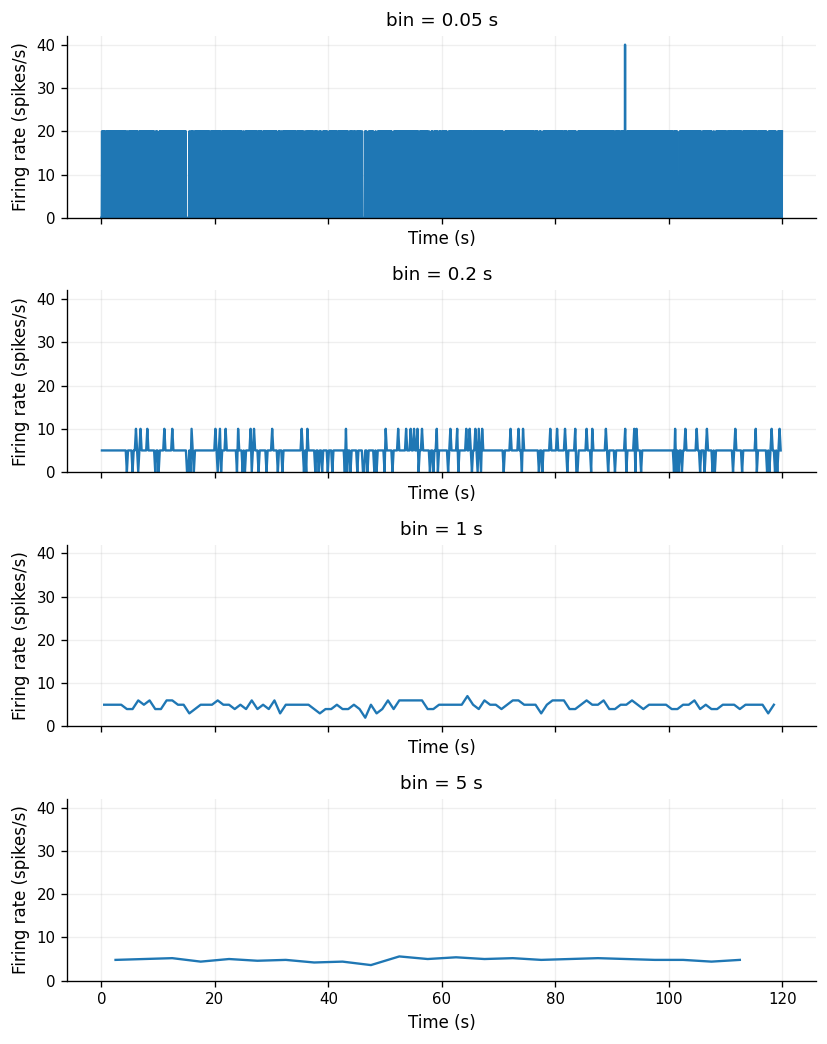

In [8]:
# Bin-size demo (single representative unit)
bin_sizes = BIN_SIZES_S
rates_per_bin = []
for bin_s in bin_sizes:
    t_s, rate_hz, _, _ = binned_firing_rate(
        stand_times,
        start_s=stand_meta["start_s"],
        stop_s=stand_meta["stop_s"],
        bin_s=bin_s,
    )
    rates_per_bin.append((bin_s, t_s, rate_hz))

max_rate = max((rate.max() for _, _, rate in rates_per_bin if rate.size), default=1.0)

fig, axes = plt.subplots(len(bin_sizes), 1, figsize=(7, 2.2 * len(bin_sizes)), sharex=True)
if len(bin_sizes) == 1:
    axes = [axes]
for ax, (bin_s, t_s, rate_hz) in zip(axes, rates_per_bin):
    plot_firing_rate(t_s, rate_hz, ax=ax, title=f"bin = {bin_s:.3g} s")
    ax.set_ylim(0, max_rate * 1.05)

fig.tight_layout()
bin_label = "_".join(_fmt_bin(b) for b in bin_sizes)
save_figure(fig, f"part3_bin_demo_{stand_meta['unit_key']}_bins_{bin_label}_fs{int(FS_SPIKE)}")


Stand vs Walk stats: {'method': 'mannwhitney_u', 'n_a': 599, 'n_b': 599, 'mean_a': 4.816360601001669, 'mean_b': 5.843071786310517, 'mean_diff': -1.026711185308848, 'pvalue': 6.029189579074553e-10, 'comparison': 'stand_vs_walk', 'unit_key': 'SPK20a', 'bin_s': 0.2}
Counts match (stand, histogram vs train): True


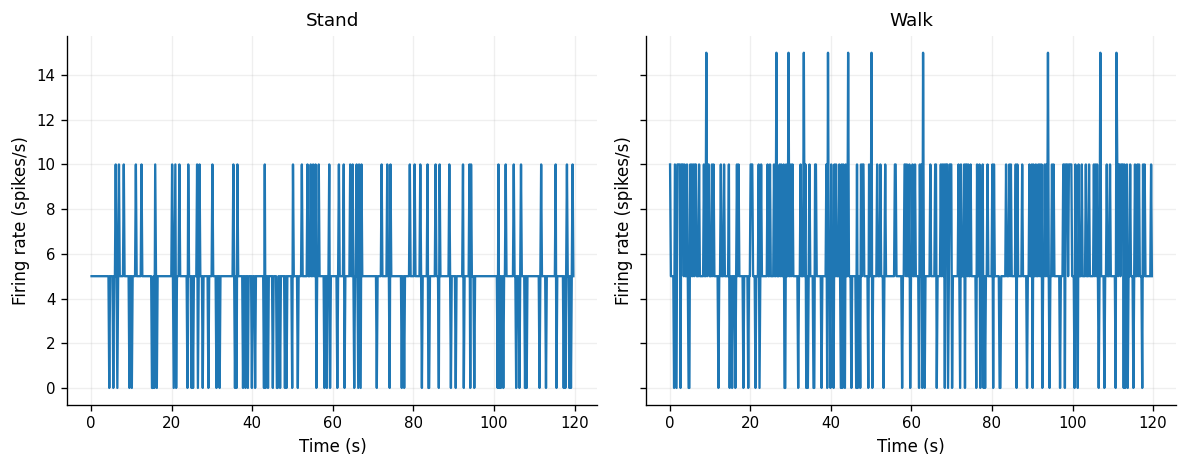

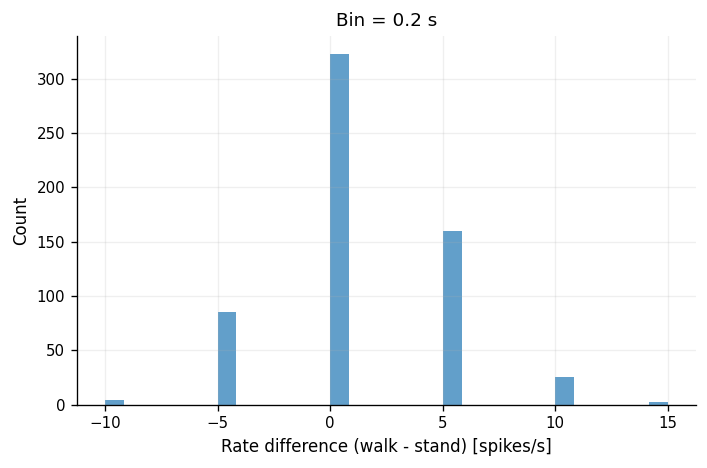

In [9]:
# Preferred bin size: stand vs walk comparison
bin_s = PREFERRED_BIN_S
t_stand, rate_stand, counts_stand, edges_stand = binned_firing_rate(
    stand_times,
    start_s=stand_meta["start_s"],
    stop_s=stand_meta["stop_s"],
    bin_s=bin_s,
)
t_walk, rate_walk, counts_walk, edges_walk = binned_firing_rate(
    walk_times,
    start_s=walk_meta["start_s"],
    stop_s=walk_meta["stop_s"],
    bin_s=bin_s,
)

ylim = compute_global_ylim([rate_stand, rate_walk])
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_firing_rate(t_stand, rate_stand, ax=axes[0], title="Stand", ylim=ylim)
plot_firing_rate(t_walk, rate_walk, ax=axes[1], title="Walk", ylim=ylim)
set_shared_limits(axes, ylim=ylim)
fig.tight_layout()
save_figure(
    fig,
    f"part3_{stand_meta['unit_key']}_stand_walk_bin{_fmt_bin(bin_s)}_fs{int(FS_SPIKE)}",
)

# Histogram of differences (walk - stand)
n_bins = min(rate_stand.size, rate_walk.size)
diffs = rate_walk[:n_bins] - rate_stand[:n_bins]
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(diffs, bins=30, color=COLORS["trace"], alpha=0.7)
ax.set_xlabel("Rate difference (walk - stand) [spikes/s]")
ax.set_ylabel("Count")
ax.set_title(f"Bin = {bin_s:.3g} s")
fig.tight_layout()
save_figure(
    fig,
    f"part3_{stand_meta['unit_key']}_walk_minus_stand_hist_bin{_fmt_bin(bin_s)}_fs{int(FS_SPIKE)}",
)

result_sw = compare_rate_samples(rate_stand, rate_walk, method="mannwhitney")
result_sw["comparison"] = "stand_vs_walk"
result_sw["unit_key"] = stand_meta["unit_key"]
result_sw["bin_s"] = float(bin_s)
print("Stand vs Walk stats:", result_sw)

# Sanity check: histogram counts vs spike-train counts
edges, effective_stop = nonoverlap_edges(stand_meta["start_s"], stand_meta["stop_s"], bin_s)
counts_train = spike_train_counts(
    stand_times,
    start_s=stand_meta["start_s"],
    stop_s=effective_stop,
    Fs=FS_SPIKE,
    bin_s=bin_s,
)
counts_hist = np.histogram(stand_times, bins=edges)[0]
print("Counts match (stand, histogram vs train):", np.array_equal(counts_hist, counts_train))


Ohad vs Sagi stats: {'method': 'mannwhitney_u', 'n_a': 599, 'n_b': 599, 'mean_a': 2.9131886477462436, 'mean_b': 4.015025041736227, 'mean_diff': -1.1018363939899838, 'pvalue': 2.0804293564247846e-13, 'comparison': 'ohad_vs_sagi', 'unit_key': 'SPK01a', 'bin_s': 0.2}


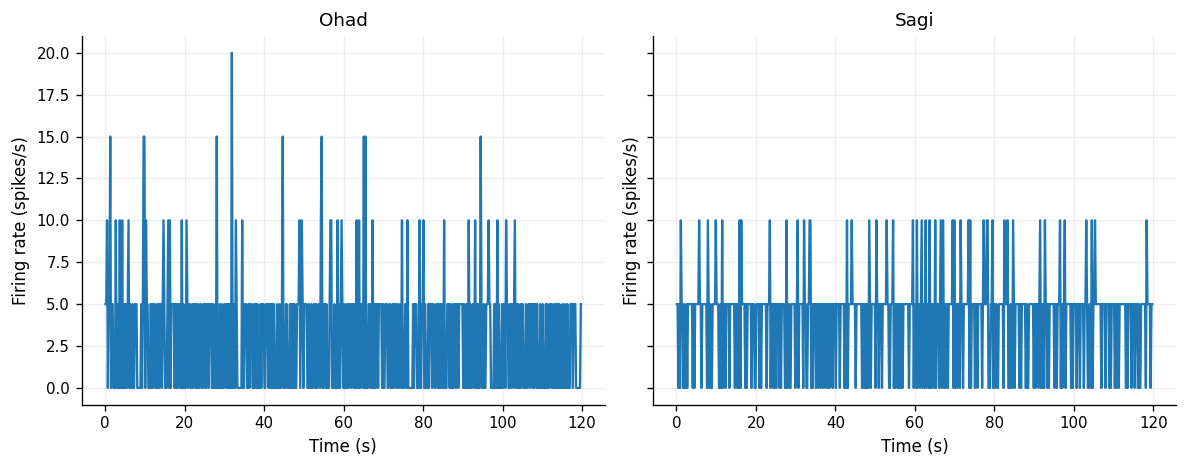

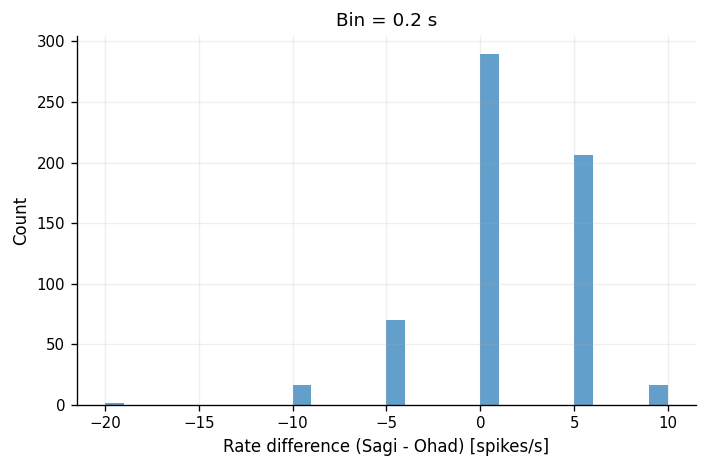

In [10]:
# Preferred bin size: people comparison
t_a, rate_a, counts_a, _ = binned_firing_rate(
    person_a_times,
    start_s=person_a_meta["start_s"],
    stop_s=person_a_meta["stop_s"],
    bin_s=bin_s,
)
t_b, rate_b, counts_b, _ = binned_firing_rate(
    person_b_times,
    start_s=person_b_meta["start_s"],
    stop_s=person_b_meta["stop_s"],
    bin_s=bin_s,
)

ylim_people = compute_global_ylim([rate_a, rate_b])
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_firing_rate(t_a, rate_a, ax=axes[0], title="Ohad", ylim=ylim_people)
plot_firing_rate(t_b, rate_b, ax=axes[1], title="Sagi", ylim=ylim_people)
set_shared_limits(axes, ylim=ylim_people)
fig.tight_layout()
save_figure(
    fig,
    f"part3_{person_a_meta['unit_key']}_ohad_sagi_bin{_fmt_bin(bin_s)}_fs{int(FS_SPIKE)}",
)

n_bins = min(rate_a.size, rate_b.size)
diffs_people = rate_b[:n_bins] - rate_a[:n_bins]
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(diffs_people, bins=30, color=COLORS["trace"], alpha=0.7)
ax.set_xlabel("Rate difference (Sagi - Ohad) [spikes/s]")
ax.set_ylabel("Count")
ax.set_title(f"Bin = {bin_s:.3g} s")
fig.tight_layout()
save_figure(
    fig,
    f"part3_{person_a_meta['unit_key']}_sagi_minus_ohad_hist_bin{_fmt_bin(bin_s)}_fs{int(FS_SPIKE)}",
)

result_people = compare_rate_samples(rate_a, rate_b, method="mannwhitney")
result_people["comparison"] = "ohad_vs_sagi"
result_people["unit_key"] = person_a_meta["unit_key"]
result_people["bin_s"] = float(bin_s)
print("Ohad vs Sagi stats:", result_people)


In [11]:
# Save Part 3 stats
import csv

stats_rows = [result_sw, result_people]
stats_path = PLOTS_FINAL_DIR / "part3_stats.csv"
with stats_path.open("w", newline="", encoding="utf-8") as handle:
    writer = csv.DictWriter(handle, fieldnames=sorted(stats_rows[0].keys()))
    writer.writeheader()
    writer.writerows(stats_rows)



# Part 4 — LFP spectrum


[<Figure size 840x480 with 1 Axes>,
 <Figure size 1200x480 with 4 Axes>,
 <Figure size 840x480 with 1 Axes>,
 <Figure size 1200x480 with 4 Axes>,
 <Figure size 840x480 with 1 Axes>,
 <Figure size 1200x480 with 4 Axes>]

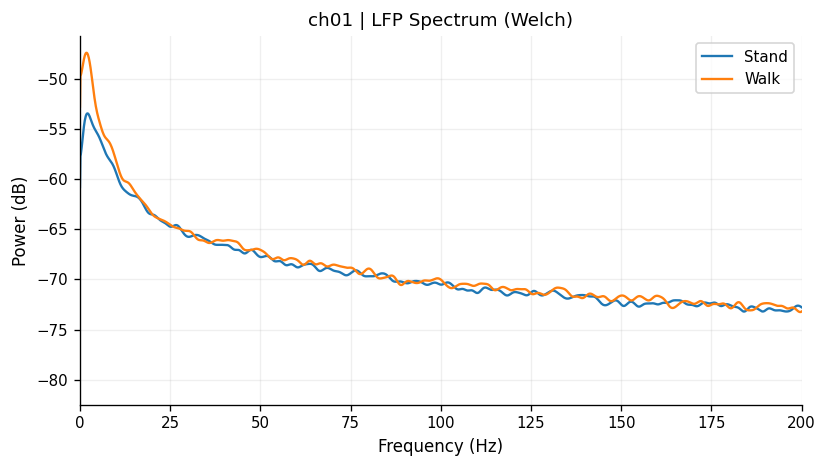

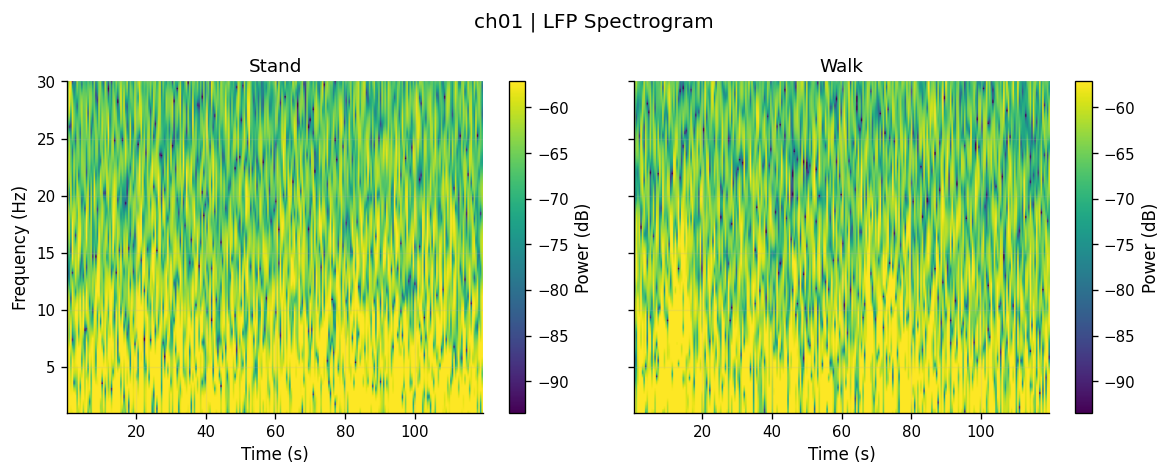

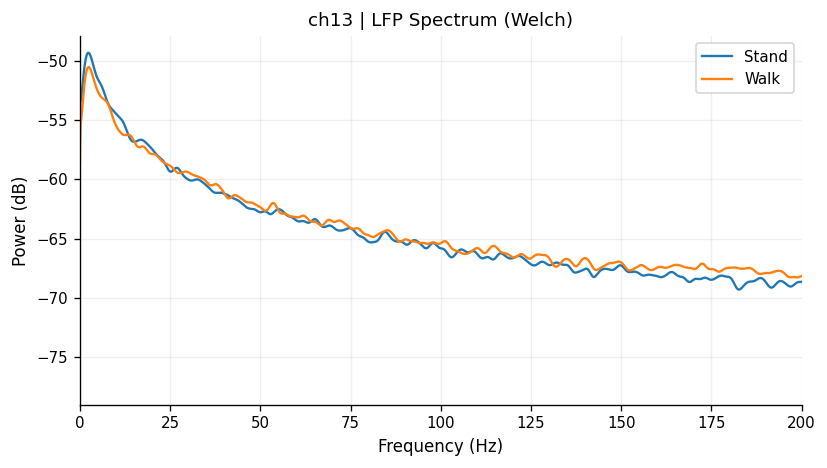

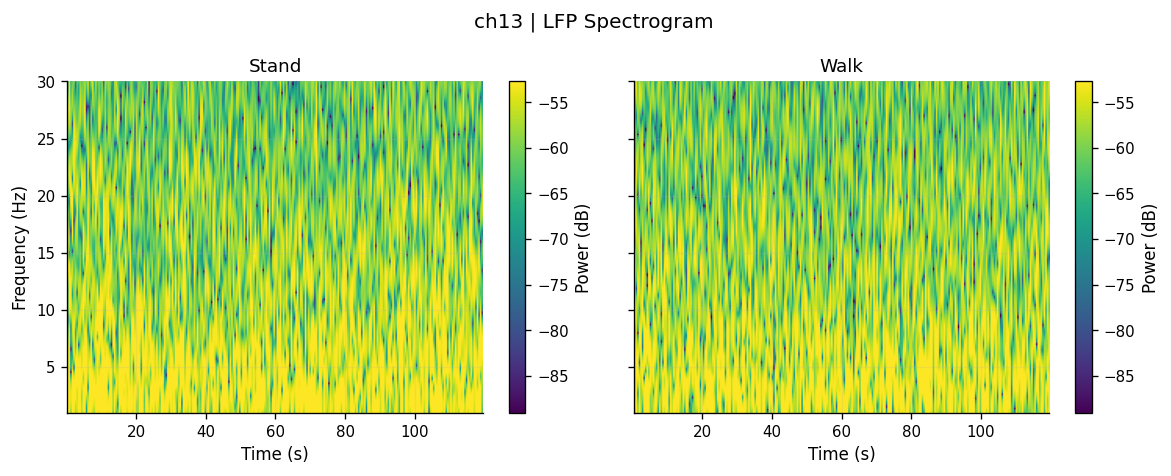

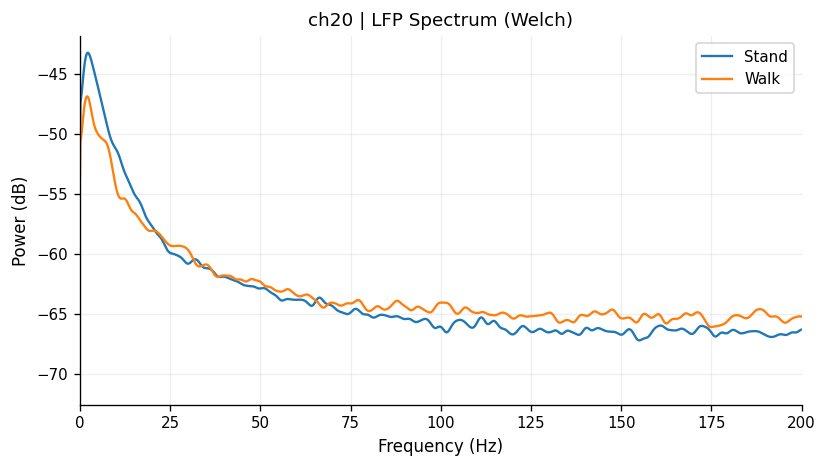

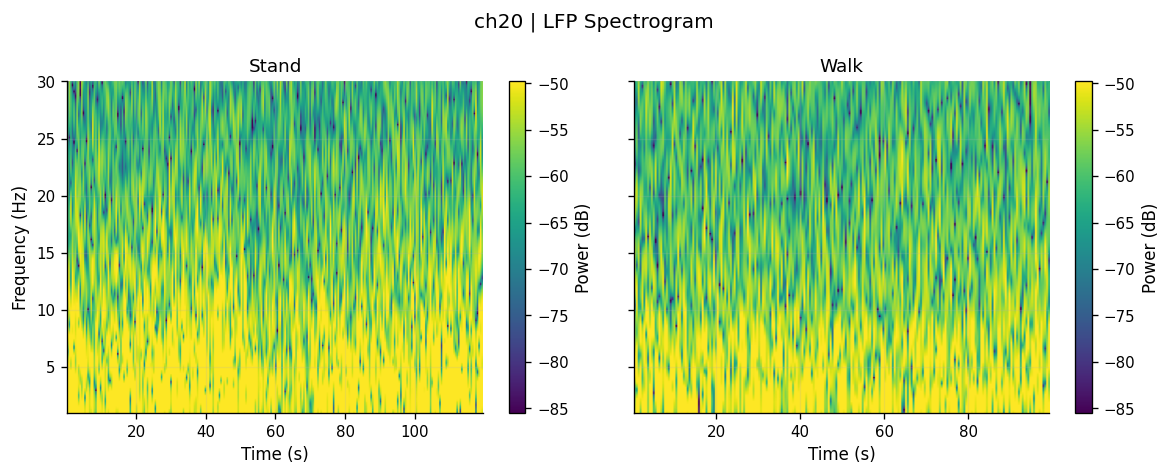

In [12]:
lfp_data = load_mat(LFP_MAT_PATH)
LFP_spectrum(lfp_data, Fs=1000.0, save_prefix="part4_lfp")


Across the three channels, the comparison between Stand and Walk reveals clear but channel-specific spectral modulations rather than a uniform global effect. In ch01, the Walk condition is characterized by a relative enhancement of low-frequency power, visible as a systematic elevation of the spectrum at the lowest frequencies and a generally steeper spectral decay, suggesting increased dominance of slow LFP fluctuations during movement. In contrast, ch13 shows largely overlapping spectra between the two conditions, with only minor broadband deviations and no pronounced redistribution of power across frequencies, indicating minimal sensitivity to the behavioral state. A different pattern emerges in ch20, where the Walk condition exhibits a relative reduction in low-frequency power accompanied by a subtle but consistent elevation at higher frequencies, producing a flatter overall spectral profile. Together, these results indicate that walking induces heterogeneous, channel-dependent changes in LFP dynamics, ranging from low-frequency enhancement to desynchronization-like spectral flattening, rather than a single uniform spectral shift across recording sites.